# `Release Highlights for scikit-learn 0.22`

To install the latest version (with pip):

In [ ]:
#! pip install --upgrade scikit-learn

In [33]:
#! conda install scikit-learn

# sklearn ensemble - StackingRegressor

In [7]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

In [8]:
X, y = load_diabetes(return_X_y=True)

In [9]:
estimators = [
    ('lr', RidgeCV()),
    ('svr', LinearSVR(random_state=42))
]

In [11]:
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [13]:
reg.fit(X_train, y_train).score(X_test, y_test)

0.23301792180475947

In [14]:
reg.get_params()

{'cv': None,
 'estimators': [('lr',
   RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
           gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)),
  ('svr', LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
             intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
             random_state=42, tol=0.0001, verbose=0))],
 'final_estimator__bootstrap': True,
 'final_estimator__ccp_alpha': 0.0,
 'final_estimator__criterion': 'mse',
 'final_estimator__max_depth': None,
 'final_estimator__max_features': 'auto',
 'final_estimator__max_leaf_nodes': None,
 'final_estimator__max_samples': None,
 'final_estimator__min_impurity_decrease': 0.0,
 'final_estimator__min_impurity_split': None,
 'final_estimator__min_samples_leaf': 1,
 'final_estimator__min_samples_split': 2,
 'final_estimator__min_weight_fraction_leaf': 0.0,
 'final_estimator__n_estimators': 10,
 'final_estimator__n_jobs': None,
 'final_estimator__oob_score': 

In [15]:
predictions = reg.predict(X_test)

In [16]:
predictions[0:5]

array([164.6, 234.8, 164.6, 256.5, 156.6])

In [17]:
reg.score(X_test, y_test) # gives R^2

0.23301792180475947

# Combine predictors using stacking¶
Stacking refers to a method to blend estimators. In this strategy, some estimators are individually fitted on some training data while a final estimator is trained using the stacked predictions of these base estimators.

In this example, we illustrate the use case in which different regressors are stacked together and a final linear penalized regressor is used to output the prediction. We compare the performance of each individual regressor with the stacking strategy. Stacking slightly improves the overall performance.

### The function plot_regression_results is used to plot the predicted and true targets.

In [14]:
import matplotlib.pyplot as plt


In [15]:
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)

# Stack of predictors on a single data set¶
It is sometimes tedious to find the model which will best perform on a given dataset. Stacking provide an alternative by combining the outputs of several learners, without the need to choose a model specifically. The performance of stacking is usually close to the best model and sometimes it can outperform the prediction performance of each individual model.

Here, we combine 3 learners (linear and non-linear) and use a ridge regressor to combine their outputs together.

In [16]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

estimators = [
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Lasso', LassoCV()),
    ('Gradient Boosting', HistGradientBoostingRegressor(random_state=0))
]
stacking_regressor = StackingRegressor(
    estimators=estimators, final_estimator=RidgeCV()
)

We used the Boston data set (prediction of house prices). We check the performance of each individual predictor as well as the stack of the regressors.

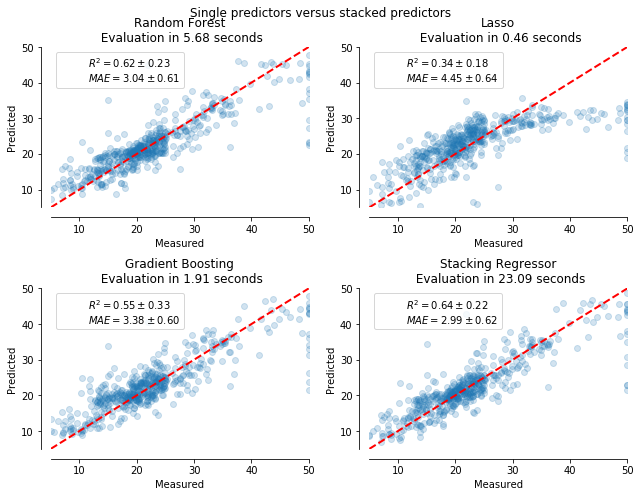

In [17]:
import time
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_validate, cross_val_predict

X, y = load_boston(return_X_y=True)

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    score = cross_validate(est, X, y,
                           scoring=['r2', 'neg_mean_absolute_error'],
                           n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)
    plot_regression_results(
        ax, y, y_pred,
        name,
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MAE={:.2f} \pm {:.2f}$')
        .format(np.mean(score['test_r2']),
                np.std(score['test_r2']),
                -np.mean(score['test_neg_mean_absolute_error']),
                np.std(score['test_neg_mean_absolute_error'])),
        elapsed_time)

plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


The stacked regressor will combine the strengths of the different regressors. However, we also see that training the stacked regressor is much more computationally expensive.

Total running time of the script: ( 0 minutes 11.613 seconds)

Estimated memory usage: 10 MB

# sklearn ensemble - StackingClassifier

Stack of estimators with a final classifier.

Stacked generalization consists in stacking the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

Note that estimators_ are fitted on the full X while final_estimator_ is trained using cross-validated predictions of the base estimators using cross_val_predict.

New in version 0.22.

In [28]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

In [29]:
X, y = load_iris(return_X_y=True)

In [30]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('svr', make_pipeline(StandardScaler(),
                          LinearSVC(random_state=42)))
]

In [31]:
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42
)

In [33]:
clf.fit(X_train, y_train).score(X_test, y_test)

0.9473684210526315

In [34]:
clf.decision_function(X_test)

array([[  7.6584112 ,   2.6481724 , -10.30658361],
       [ -2.60404259,   2.40663689,   0.1974057 ],
       [ -1.79951022,   2.7749923 ,  -0.97548208],
       [ -2.70041315,   2.82746133,  -0.12704818],
       [  7.24137016,   2.66823871,  -9.90960887],
       [ -2.10526668,   2.40578998,  -0.3005233 ],
       [ -4.67840148,   2.11076279,   2.5676387 ],
       [ -5.60250749,   1.13599716,   4.46651033],
       [ -6.20674195,   1.34175301,   4.86498894],
       [ -6.70934326,   1.14686914,   5.56247411],
       [ -4.31435964,   2.28283312,   2.03152652],
       [ -6.72334293,   1.00853961,   5.71480332],
       [ -1.46097499,   2.94540667,  -1.48443168],
       [ -2.53866806,   2.36957936,   0.1690887 ],
       [  7.97387836,   2.64256813, -10.6164465 ],
       [  8.45875066,   2.62087842, -11.07962908],
       [  7.52236561,   2.62805248, -10.15041809],
       [ -2.82610069,   2.65351721,   0.17258348],
       [  9.57797158,   2.64348593, -12.22145751],
       [ -1.74640144,   2.75349

In [35]:
clf.get_params()

{'cv': None,
 'estimators': [('rf',
   RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                          criterion='gini', max_depth=None, max_features='auto',
                          max_leaf_nodes=None, max_samples=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10,
                          n_jobs=None, oob_score=False, random_state=42, verbose=0,
                          warm_start=False)),
  ('svr', Pipeline(memory=None,
            steps=[('standardscaler',
                    StandardScaler(copy=True, with_mean=True, with_std=True)),
                   ('linearsvc',
                    LinearSVC(C=1.0, class_weight=None, dual=True,
                              fit_intercept=True, intercept_scaling=1,
                              loss='squared_hinge', max_iter=1000,
       

In [36]:
predictions = clf.predict(X_test)

In [37]:
predictions[0:5]

array([0, 1, 1, 1, 0])

In [38]:
clf.predict_proba(X_test)

array([[9.93374859e-01, 6.62512538e-03, 1.56680537e-08],
       [5.97103662e-03, 8.95695063e-01, 9.83339003e-02],
       [9.97412254e-03, 9.67288228e-01, 2.27376498e-02],
       [3.76338247e-03, 9.46899183e-01, 4.93374344e-02],
       [9.89779918e-01, 1.02200468e-02, 3.52340921e-08],
       [1.01940588e-02, 9.27842258e-01, 6.19636832e-02],
       [4.36355192e-04, 3.87558019e-01, 6.12005626e-01],
       [4.09070388e-05, 3.45377011e-02, 9.65421392e-01],
       [1.50998924e-05, 2.86578469e-02, 9.71327053e-01],
       [4.62591315e-06, 1.19428278e-02, 9.88052546e-01],
       [7.66767143e-04, 5.62066768e-01, 4.37166464e-01],
       [3.92891180e-06, 8.95748735e-03, 9.91038584e-01],
       [1.19119745e-02, 9.76452215e-01, 1.16358106e-02],
       [6.60512879e-03, 8.94347009e-01, 9.90478625e-02],
       [9.95185555e-01, 4.81443636e-03, 8.39901895e-09],
       [9.97093431e-01, 2.90656577e-03, 3.26080893e-09],
       [9.92566597e-01, 7.43338230e-03, 2.09684928e-08],
       [3.83414702e-03, 9.19256

In [39]:
clf.score(X_test , y_test)# Return the mean accuracy on the given test data and labels.

0.9473684210526315

# New plotting API

# roc_curve

# precision_recall_curve

# confusion_matrix
A new plotting API is available for creating visualizations. This new API allows for quickly adjusting the visuals of a plot without involving any recomputation. It is also possible to add different plots to the same figure. The following example illustrates plot_roc_curve, but other plots utilities are supported like `plot_partial_dependence`, `plot_precision_recall_curve`, and `plot_confusion_matrix`. Read more about this new API in the User Guide.

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

In [46]:
X, y = make_classification(random_state=0)

In [47]:
X[0:5]
X.shape

(100, 20)

In [48]:
y.shape

(100,)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [50]:
svc = SVC(random_state=42)
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [51]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

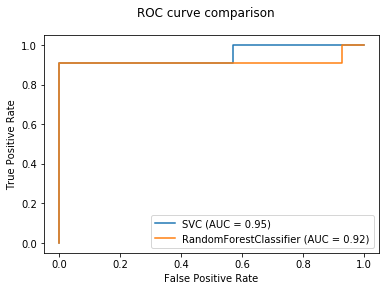

In [53]:

svc_disp = plot_roc_curve(svc, X_test, y_test)
rfc_disp = plot_roc_curve(rfc, X_test, y_test, ax=svc_disp.ax_)
rfc_disp.figure_.suptitle("ROC curve comparison")

plt.show()

# Permutation-based feature importance
The inspection.permutation_importance can be used to get an estimate of the importance of each feature, for any fitted estimator:

Permutation importance for feature evaluation [BRE].

The estimator is required to be a fitted estimator. X can be the data set used to train the estimator or a hold-out set. The permutation importance of a feature is calculated as follows. First, a baseline metric, defined by scoring, is evaluated on a (potentially different) dataset defined by the X. Next, a feature column from the validation set is permuted and the metric is evaluated again. The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column.

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [55]:
X, y = make_classification(random_state=0, n_features=5, n_informative=3)

In [56]:
rf = RandomForestClassifier(random_state=0).fit(X, y)

In [57]:
result = permutation_importance(rf, X, y, n_repeats=10, random_state=0,
                                n_jobs=-1)

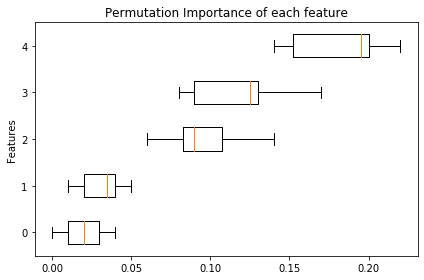

In [58]:
fig, ax = plt.subplots()

sorted_idx = result.importances_mean.argsort()

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=range(X.shape[1]))

ax.set_title("Permutation Importance of each feature")

ax.set_ylabel("Features")

fig.tight_layout()

plt.show()

# Native support for missing values for gradient boosting 
The ensemble.HistGradientBoostingClassifier and ensemble.HistGradientBoostingRegressor now have native support for missing values (NaNs). This means that there is no need for imputing data when training or predicting.

In [59]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
import numpy as np

In [60]:
X = np.array([0, 1, 2, np.nan]).reshape(-1, 1)
y = [0, 0, 1, 1]

In [61]:
X

array([[ 0.],
       [ 1.],
       [ 2.],
       [nan]])

In [62]:
y

[0, 0, 1, 1]

In [63]:
gbdt = HistGradientBoostingClassifier(min_samples_leaf=1).fit(X, y)
print(gbdt.predict(X))

[0 0 1 1]


# Precomputed sparse nearest neighbors graph¶
Most estimators based on nearest neighbors graphs now accept precomputed sparse graphs as input, to reuse the same graph for multiple estimator fits. To use this feature in a pipeline, one can use the memory parameter, along with one of the two new transformers, `neighbors.KNeighborsTransformer` and `neighbors.RadiusNeighborsTransformer`. The precomputation can also be performed by custom estimators to use alternative implementations, such as approximate nearest neighbors methods. See more details in the User Guide.

In [59]:
from tempfile import TemporaryDirectory
from sklearn.neighbors import KNeighborsTransformer
from sklearn.manifold import Isomap
from sklearn.pipeline import make_pipeline

In [60]:
X, y = make_classification(random_state=0)

In [61]:
with TemporaryDirectory(prefix="sklearn_cache_") as tmpdir:
    estimator = make_pipeline(
        KNeighborsTransformer(n_neighbors=10, mode='distance'),
        Isomap(n_neighbors=10, metric='precomputed'),
        memory=tmpdir)
    estimator.fit(X)

    # We can decrease the number of neighbors and the graph will not be
    # recomputed.
    estimator.set_params(isomap__n_neighbors=5)
    estimator.fit(X)

# KNN Based Imputation
We now support imputation for completing missing values using k-Nearest Neighbors.

Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close. By default, a euclidean distance metric that supports missing values, `nan_euclidean_distances`, is used to find the nearest neighbors.

In [69]:
import numpy as np
from sklearn.impute import KNNImputer


In [70]:

X = [[1, 2, np.nan], [3, 4, 3], [np.nan, 6, 5], [8, 8, 7]]

In [71]:
X

[[1, 2, nan], [3, 4, 3], [nan, 6, 5], [8, 8, 7]]

In [72]:
imputer = KNNImputer(n_neighbors=2)

In [73]:
print(imputer.fit_transform(X))

[[1.  2.  4. ]
 [3.  4.  3. ]
 [5.5 6.  5. ]
 [8.  8.  7. ]]


# Tree pruning¶
It is now possible to prune most tree-based estimators once the trees are built. The pruning is based on minimal cost-complexity.

In [74]:
X, y = make_classification(random_state=0)


In [75]:
rf = RandomForestClassifier(random_state=0, ccp_alpha=0).fit(X, y)

In [71]:
print("Average number of nodes without pruning {:.1f}".format(
    np.mean([e.tree_.node_count for e in rf.estimators_])))

Average number of nodes without pruning 22.3


In [72]:
rf = RandomForestClassifier(random_state=0, ccp_alpha=0.05).fit(X, y)

In [73]:
print("Average number of nodes with pruning {:.1f}".format(
    np.mean([e.tree_.node_count for e in rf.estimators_])))

Average number of nodes with pruning 6.4


# Retrieve dataframes from OpenML
datasets.fetch_openml can now return pandas dataframe and thus properly handle datasets with heterogeneous data:

In [74]:
from sklearn.datasets import fetch_openml

titanic = fetch_openml('titanic', version=1, as_frame=True)

print(titanic.data.head()[['pclass', 'embarked']])

   pclass embarked
0     1.0        S
1     1.0        S
2     1.0        S
3     1.0        S
4     1.0        S


# Checking scikit-learn compatibility of an estimator
Developers can check the compatibility of their scikit-learn compatible estimators using check_estimator. For instance, the `check_estimator(LinearSVC)` passes.

We now provide a pytest specific decorator which allows pytest to run all checks independently and report the checks that are failing.

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.estimator_checks import parametrize_with_checks

In [76]:
@parametrize_with_checks([LogisticRegression, DecisionTreeRegressor])
def test_sklearn_compatible_estimator(estimator, check):
    check(estimator)

# ROC AUC now supports multiclass classification

The roc_auc_score function can also be used in multi-class classification. Two averaging strategies are currently supported: the one-vs-one algorithm computes the average of the pairwise ROC AUC scores, and the one-vs-rest algorithm computes the average of the ROC AUC scores for each class against all other classes. In both cases, the multiclass ROC AUC scores are computed from the probability estimates that a sample belongs to a particular class according to the model. The OvO and OvR algorithms support weighting uniformly (average='macro') and weighting by the prevalence (average='weighted').

In [76]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

In [77]:
X, y = make_classification(n_classes=4, n_informative=16)

In [78]:
clf = SVC(decision_function_shape='ovo', probability=True).fit(X, y)

In [79]:
print(roc_auc_score(y, clf.predict_proba(X), multi_class='ovo'))

0.9966523025469515
